## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import ElasticNet
import joblib
from tqdm import tqdm
import yaml

## Config

In [2]:
%cd ..

C:\Yellow Taxi Project\SimpleOps\project


In [11]:
import yaml

with open('params.yaml') as conf_file:
    config = yaml.safe_load(conf_file)

print(config)

{'base': {'random_seed': 42}, 'data': {'raw_data_parquet': 'data/raw/yellow_tripdata_2023-01.parquet', 'raw_data_csv': 'data/raw/yellow_tripdata_2023-01.csv', 'processed_data_csv': 'data/processed/yellow_tripdata_2023-01.csv', 'train_data_csv': 'data/processed/train_data.csv', 'val_data_csv': 'data/processed/val_data.csv', 'test_size': 0.2}, 'train': {'PyNN': {'lr': 0.002, 'batch_size': 1024, 'num_workers': 0, 'patience': 20, 'patience_counter': 0, 'epochs': 100, 'model_path': 'models/PyNN_model.pt'}, 'XGBoost': {'tree_method': 'hist', 'device': 'cuda', 'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'objective': 'reg:squarederror', 'random_state': 42, 'early_stopping_rounds': 20}, 'LightGBM': {'device': 'gpu', 'num_leaves': 31, 'learning_rate': 0.05, 'n_estimators': 500, 'min_child_samples': 20, 'early_stopping_rounds': 20, 'random_state': 42}, 'TabNet': {'eval_metric': ['rmse'], 'max_epochs': 20, 'patience': 5, 'batch_size': 1024

## Reading Data

In [4]:
# 1. Load and preprocess data
# df = pd.read_parquet('../data/raw/yellow_tripdata_2023-01.parquet')
df = pd.read_parquet(config['data']['raw_data_parquet'])
df.to_csv(config['data']['raw_data_csv'])
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds()
df = df[(df['trip_duration'] >= 60) & (df['trip_duration'] <= 7200)]

## Fill NA Values

In [5]:
for col in ['passenger_count', 'RatecodeID', 'congestion_surcharge', 'airport_fee']:
    df[col] = df[col].fillna(df[col].mean())

# Fill categorical column with mode
for col in ['store_and_fwd_flag']:
    df[col] = df[col].fillna(df[col].mode()[0])

## Feature Engineering

In [6]:
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['pickup_weekday'] = df['tpep_pickup_datetime'].dt.weekday
df['is_weekend'] = df['pickup_weekday'].isin([5, 6]).astype(int)
df['pickup_day'] = df['tpep_pickup_datetime'].dt.day
df['month'] = df['tpep_pickup_datetime'].dt.month
df['is_peak'] = ((df['pickup_hour'].between(7,9)) | (df['pickup_hour'].between(16,18))).astype(int)

def time_of_day(hour):
    if hour < 6: return 'night'
    elif hour < 12: return 'morning'
    elif hour < 18: return 'afternoon'
    else: return 'evening'
df['time_of_day'] = df['pickup_hour'].apply(time_of_day)

categorical_cols = [
    'VendorID', 'RatecodeID', 'store_and_fwd_flag', 'payment_type',
    'PULocationID', 'DOLocationID', 'time_of_day'
]
numerical_cols = [
    'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
    'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge',
    'pickup_hour', 'pickup_weekday', 'is_weekend', 'pickup_day', 'month', 'is_peak', 'manhattan_dist'
]
numerical_cols = [col for col in numerical_cols if col in df.columns]

# Label encode categoricals
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Standardize numerical features
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

df.to_csv(config['data']['processed_data_csv'])

In [7]:
# Prepare data
X = df[categorical_cols + numerical_cols]
y = df['trip_duration'].values.astype(np.float32)

## Train Test Split

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=config['data']['test_size'], random_state=config['base']['random_seed'])

y_train_series = pd.Series(y_train, name='trip_duration', index=X_train.index)

# Combine X and y into one training DataFrame
train_df = pd.concat([X_train, y_train_series], axis=1)

y_val_series = pd.Series(y_val, name='trip_duration', index=X_val.index)

# Combine X and y into one training DataFrame
val_df = pd.concat([X_val, y_val_series], axis=1)

train_df.to_csv(config['data']['train_data_csv'])
val_df.to_csv(config['data']['val_data_csv'])

## 1. PyTorch Neural Network

In [9]:
# ========== PyTorch Neural Network ==========
class TaxiDataset(Dataset):
    def __init__(self, X, y, categorical_cols, numerical_cols):
        self.X_cat = X[categorical_cols].values.astype(np.int64)
        self.X_num = X[numerical_cols].values.astype(np.float32)
        self.y = y.astype(np.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X_cat[idx], self.X_num[idx], self.y[idx]

train_ds = TaxiDataset(X_train, y_train, categorical_cols, numerical_cols)
val_ds = TaxiDataset(X_val, y_val, categorical_cols, numerical_cols)
train_loader = DataLoader(train_ds, batch_size=2048, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=2048, shuffle=False, num_workers=2, pin_memory=True)

cat_dims = [int(df[col].nunique()) for col in categorical_cols]
emb_dims = [(x, min(50, (x+1)//2)) for x in cat_dims]

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm

# Print CUDA info for debugging
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("CUDA device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

class TaxiNet(nn.Module):
    def __init__(self, emb_dims, n_num):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(x, y) for x, y in emb_dims])
        emb_dim_sum = sum([y for x, y in emb_dims])
        self.fc = nn.Sequential(
            nn.Linear(emb_dim_sum + n_num, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.Linear(128, 1)
        )
    def forward(self, x_cat, x_num):
        x = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        x = torch.cat(x, 1)
        x = torch.cat([x, x_num], 1)
        return self.fc(x).squeeze(1)

# Set device and move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TaxiNet(emb_dims, len(numerical_cols)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=config['train']['PyNN']['lr'])
criterion = nn.MSELoss()

# Use a reasonable batch size and num_workers=0 for debugging
BATCH_SIZE = config['train']['PyNN']['batch_size']
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=config['train']['PyNN']['num_workers'])
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=config['train']['PyNN']['num_workers'])

# Training loop with tqdm and early stopping
best_r2 = -np.inf
patience, patience_counter = config['train']['PyNN']['patience'], config['train']['PyNN']['patience_counter']
EPOCHS = config['train']['PyNN']['epochs']

for epoch in range(EPOCHS):
    model.train()
    train_losses = []
    for x_cat, x_num, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        x_cat, x_num, y_batch = x_cat.to(device), x_num.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(x_cat, x_num)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    model.eval()
    val_preds = []
    val_targets = []
    with torch.no_grad():
        for x_cat, x_num, y_batch in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            x_cat, x_num = x_cat.to(device), x_num.to(device)
            preds = model(x_cat, x_num).cpu().numpy()
            val_preds.append(preds)
            val_targets.append(y_batch.numpy())
    val_preds = np.concatenate(val_preds)
    val_targets = np.concatenate(val_targets)
    val_rmse = np.sqrt(mean_squared_error(val_targets, val_preds))
    val_r2 = r2_score(val_targets, val_preds)
    print(f"Epoch {epoch+1:02d} | Train Loss: {np.mean(train_losses):.4f} | Val RMSE: {val_rmse:.2f} | Val R2: {val_r2:.4f}")
    if val_r2 > best_r2:
        best_r2 = val_r2
        patience_counter = 0
        torch.save(model.state_dict(), config['train']['PyNN']['model_path'])
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Load best model and get predictions for stacking
model.load_state_dict(torch.load(config['train']['PyNN']['model_path']))
model.eval()

def get_nn_preds(X_df):
    ds = TaxiDataset(X_df, np.zeros(len(X_df)), categorical_cols, numerical_cols)
    dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=config['train']['PyNN']['num_workers'])
    preds = []
    with torch.no_grad():
        for x_cat, x_num, _ in tqdm(dl, desc="Predicting"):
            x_cat, x_num = x_cat.to(device), x_num.to(device)
            batch_preds = model(x_cat, x_num).cpu().numpy()
            preds.append(batch_preds)
    return np.concatenate(preds)

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA device count: 1
CUDA device name: NVIDIA GeForce RTX 4050 Laptop GPU


Epoch 1 [Val]: 100%|████████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 138.59it/s]


Epoch 01 | Train Loss: 272208.5098 | Val RMSE: 191.37 | Val R2: 0.9149


Epoch 2 [Val]: 100%|████████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 143.31it/s]


Epoch 02 | Train Loss: 39696.6296 | Val RMSE: 799.86 | Val R2: -0.4875


Epoch 3 [Val]: 100%|████████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 141.93it/s]


Epoch 03 | Train Loss: 37718.7621 | Val RMSE: 315.17 | Val R2: 0.7690


Epoch 4 [Val]: 100%|████████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 140.68it/s]


Epoch 04 | Train Loss: 36142.9579 | Val RMSE: 435.71 | Val R2: 0.5586


Epoch 5 [Val]: 100%|████████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 145.18it/s]


Epoch 05 | Train Loss: 33396.1792 | Val RMSE: 2097.59 | Val R2: -9.2299


Epoch 6 [Val]: 100%|████████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 143.53it/s]


Epoch 06 | Train Loss: 30999.6511 | Val RMSE: 4196.10 | Val R2: -39.9375


Epoch 7 [Val]: 100%|████████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 146.33it/s]


Epoch 07 | Train Loss: 29802.1141 | Val RMSE: 3341.53 | Val R2: -24.9609


Epoch 8 [Val]: 100%|████████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 139.66it/s]


Epoch 08 | Train Loss: 29094.0575 | Val RMSE: 1462.11 | Val R2: -3.9704


Epoch 9 [Val]: 100%|████████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 142.94it/s]


Epoch 09 | Train Loss: 28477.1568 | Val RMSE: 186.02 | Val R2: 0.9195


Epoch 10 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 136.01it/s]


Epoch 10 | Train Loss: 28197.7283 | Val RMSE: 456.79 | Val R2: 0.5149


Epoch 11 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 139.00it/s]


Epoch 11 | Train Loss: 27902.5162 | Val RMSE: 500.03 | Val R2: 0.4187


Epoch 12 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 141.65it/s]


Epoch 12 | Train Loss: 27711.8209 | Val RMSE: 466.64 | Val R2: 0.4937


Epoch 13 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 143.29it/s]


Epoch 13 | Train Loss: 27609.9848 | Val RMSE: 376.40 | Val R2: 0.6706


Epoch 14 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 143.43it/s]


Epoch 14 | Train Loss: 27285.1347 | Val RMSE: 289.72 | Val R2: 0.8048


Epoch 15 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 145.77it/s]


Epoch 15 | Train Loss: 27334.1034 | Val RMSE: 642.42 | Val R2: 0.0405


Epoch 16 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 143.41it/s]


Epoch 16 | Train Loss: 27204.0180 | Val RMSE: 501.19 | Val R2: 0.4160


Epoch 17 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 142.90it/s]


Epoch 17 | Train Loss: 27022.1722 | Val RMSE: 450.81 | Val R2: 0.5275


Epoch 18 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 139.06it/s]


Epoch 18 | Train Loss: 26859.7548 | Val RMSE: 928.84 | Val R2: -1.0059


Epoch 19 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 142.60it/s]


Epoch 19 | Train Loss: 26947.7874 | Val RMSE: 1040.57 | Val R2: -1.5175


Epoch 20 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 140.58it/s]


Epoch 20 | Train Loss: 27023.3390 | Val RMSE: 303.96 | Val R2: 0.7852


Epoch 21 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 146.85it/s]


Epoch 21 | Train Loss: 26759.7319 | Val RMSE: 202.84 | Val R2: 0.9043


Epoch 22 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 143.67it/s]


Epoch 22 | Train Loss: 26467.3341 | Val RMSE: 176.46 | Val R2: 0.9276


Epoch 23 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 137.13it/s]


Epoch 23 | Train Loss: 26581.9681 | Val RMSE: 931.52 | Val R2: -1.0175


Epoch 24 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 141.50it/s]


Epoch 24 | Train Loss: 26401.4688 | Val RMSE: 838.50 | Val R2: -0.6347


Epoch 25 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 142.02it/s]


Epoch 25 | Train Loss: 26442.6439 | Val RMSE: 182.99 | Val R2: 0.9221


Epoch 26 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 141.26it/s]


Epoch 26 | Train Loss: 26357.0774 | Val RMSE: 182.15 | Val R2: 0.9229


Epoch 27 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 137.21it/s]


Epoch 27 | Train Loss: 26431.7483 | Val RMSE: 207.67 | Val R2: 0.8997


Epoch 28 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 140.21it/s]


Epoch 28 | Train Loss: 26340.5622 | Val RMSE: 167.53 | Val R2: 0.9347


Epoch 29 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 139.04it/s]


Epoch 29 | Train Loss: 26299.1054 | Val RMSE: 317.48 | Val R2: 0.7657


Epoch 30 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 137.28it/s]


Epoch 30 | Train Loss: 26289.2967 | Val RMSE: 243.65 | Val R2: 0.8620


Epoch 31 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 139.40it/s]


Epoch 31 | Train Loss: 26387.7155 | Val RMSE: 235.69 | Val R2: 0.8708


Epoch 32 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 143.93it/s]


Epoch 32 | Train Loss: 26384.7327 | Val RMSE: 238.68 | Val R2: 0.8675


Epoch 33 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 142.02it/s]


Epoch 33 | Train Loss: 26350.3017 | Val RMSE: 448.88 | Val R2: 0.5315


Epoch 34 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 143.14it/s]


Epoch 34 | Train Loss: 26283.5329 | Val RMSE: 373.00 | Val R2: 0.6765


Epoch 35 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 139.97it/s]


Epoch 35 | Train Loss: 26347.8904 | Val RMSE: 541.96 | Val R2: 0.3171


Epoch 36 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 144.36it/s]


Epoch 36 | Train Loss: 26017.7362 | Val RMSE: 1460.01 | Val R2: -3.9561


Epoch 37 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 136.20it/s]


Epoch 37 | Train Loss: 26071.8235 | Val RMSE: 625.04 | Val R2: 0.0917


Epoch 38 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 129.55it/s]


Epoch 38 | Train Loss: 26093.3465 | Val RMSE: 1457.18 | Val R2: -3.9369


Epoch 39 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:03<00:00, 161.56it/s]


Epoch 39 | Train Loss: 26030.3202 | Val RMSE: 2950.84 | Val R2: -19.2452


Epoch 40 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:03<00:00, 160.79it/s]


Epoch 40 | Train Loss: 26062.0491 | Val RMSE: 578.20 | Val R2: 0.2227


Epoch 41 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 142.89it/s]


Epoch 41 | Train Loss: 26019.3332 | Val RMSE: 1409.99 | Val R2: -3.6223


Epoch 42 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 136.86it/s]


Epoch 42 | Train Loss: 26021.9183 | Val RMSE: 422.07 | Val R2: 0.5858


Epoch 43 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 142.85it/s]


Epoch 43 | Train Loss: 26077.7572 | Val RMSE: 448.80 | Val R2: 0.5317


Epoch 44 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 137.10it/s]


Epoch 44 | Train Loss: 26021.1056 | Val RMSE: 219.80 | Val R2: 0.8877


Epoch 45 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 138.74it/s]


Epoch 45 | Train Loss: 25905.3692 | Val RMSE: 347.05 | Val R2: 0.7200


Epoch 46 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 134.44it/s]


Epoch 46 | Train Loss: 26013.0753 | Val RMSE: 276.77 | Val R2: 0.8219


Epoch 47 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:04<00:00, 128.68it/s]


Epoch 47 | Train Loss: 25959.7584 | Val RMSE: 380.04 | Val R2: 0.6642


Epoch 48 [Val]: 100%|███████████████████████████████████████████████████████████████████████████████| 592/592 [00:03<00:00, 168.36it/s]

Epoch 48 | Train Loss: 25836.1417 | Val RMSE: 171.06 | Val R2: 0.9320
Early stopping triggered.



C:\Users\Sriram\AppData\Local\Temp\ipykernel_97364\550459154.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(config['train']['PyNN']['

## 1. PyTorch Neural Network Evaluation

In [13]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# After training and loading best model weights
model.load_state_dict(torch.load(config['train']['PyNN']['model_path']))
model.eval()

# Get predictions on validation set
val_preds = []
val_targets = []
with torch.no_grad():
    for x_cat, x_num, y_batch in val_loader:
        x_cat, x_num = x_cat.to(device), x_num.to(device)
        preds = model(x_cat, x_num).cpu().numpy()
        val_preds.append(preds)
        val_targets.append(y_batch.numpy())
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Remove any NaNs just in case
mask = ~np.isnan(val_preds) & ~np.isnan(val_targets)
val_preds = val_preds[mask]
val_targets = val_targets[mask]

# Calculate RMSE and R²
rmse = np.sqrt(mean_squared_error(val_targets, val_preds))
r2 = r2_score(val_targets, val_preds)
print(f"PyTorch NN - RMSE: {rmse:.2f}, R²: {r2:.4f}")


C:\Users\Sriram\AppData\Local\Temp\ipykernel_97364\2558338722.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(config['train']['PyNN']['m

PyTorch NN - RMSE: 167.53, R²: 0.9347


## XGBoost

In [14]:
# ========== XGBoost with GPU ==========
xgb_model = xgb.XGBRegressor(
    tree_method=config['train']['XGBoost']['tree_method'],
    device = config['train']['XGBoost']['device'],
    n_estimators=config['train']['XGBoost']['n_estimators'],
    max_depth=config['train']['XGBoost']['max_depth'],
    learning_rate=config['train']['XGBoost']['learning_rate'],
    subsample=config['train']['XGBoost']['subsample'],
    colsample_bytree=config['train']['XGBoost']['colsample_bytree'],
    objective=config['train']['XGBoost']['objective'],
    random_state=config['train']['XGBoost']['random_state'],
    early_stopping_rounds=config['train']['XGBoost']['early_stopping_rounds']
)
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device='cuda', early_stopping_rounds=20,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [15]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predict on validation set
booster = xgb_model.get_booster()
dval = xgb.DMatrix(X_val)
y_pred = booster.predict(dval)
# y_pred = xgb_model.predict(X_val)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

# Compute R² score
r2 = r2_score(y_val, y_pred)

print(f"XGBoost (GPU) - RMSE: {rmse:.2f}, R²: {r2:.4f}")

XGBoost (GPU) - RMSE: 146.63, R²: 0.9500


## LightGBM

In [16]:
# ========== LightGBM with GPU ==========
lgb_model = lgb.LGBMRegressor(
    device=config['train']['LightGBM']['device'],
    num_leaves=config['train']['LightGBM']['num_leaves'],
    learning_rate=config['train']['LightGBM']['learning_rate'],
    n_estimators=config['train']['LightGBM']['n_estimators'],
    min_child_samples=config['train']['LightGBM']['min_child_samples'],
    early_stopping_rounds=config['train']['LightGBM']['early_stopping_rounds'],
    random_state=config['train']['LightGBM']['random_state'],
    verbose = 0
)
lgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20


LGBMRegressor(device='gpu', early_stopping_rounds=20, learning_rate=0.05,
              n_estimators=500, random_state=42, verbose=0)

In [17]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predict on validation set
y_pred = lgb_model.predict(X_val)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

# Compute R² score
r2 = r2_score(y_val, y_pred)

print(f"LGB_Model (GPU) - RMSE: {rmse:.2f}, R²: {r2:.4f}")

LGB_Model (GPU) - RMSE: 155.88, R²: 0.9435


## Plot

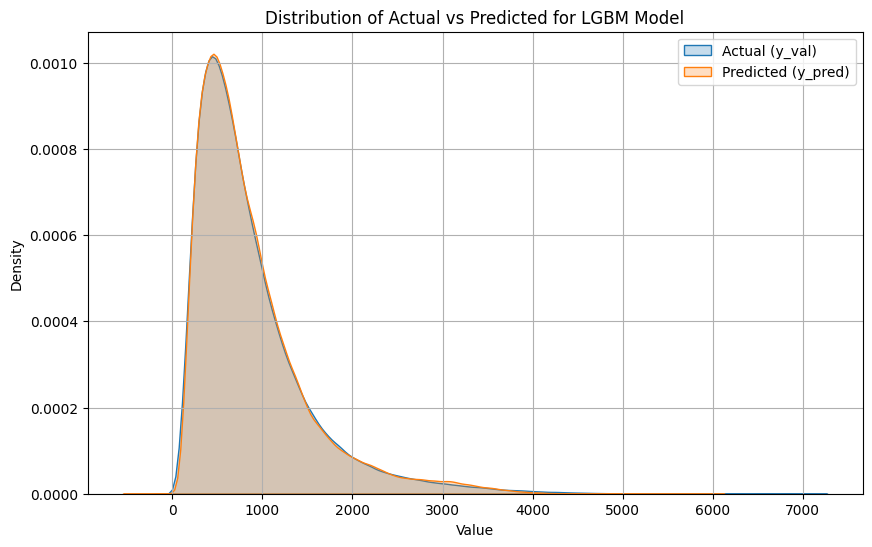

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_val and y_pred are lists, Series, or arrays
df = pd.DataFrame({'y_val': y_val, 'y_pred': y_pred})

plt.figure(figsize=(10, 6))
sns.kdeplot(df['y_val'], label='Actual (y_val)', fill=True)
sns.kdeplot(df['y_pred'], label='Predicted (y_pred)', fill=True)
plt.title('Distribution of Actual vs Predicted for LGBM Model')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)

plt.savefig(config['reports']['kde']['lgbm'])
plt.show()

## TabNet Regressor

In [19]:
from pytorch_tabnet.tab_model import TabNetRegressor

tabnet = TabNetRegressor(device_name='cuda' if torch.cuda.is_available() else 'cpu')
tabnet.fit(
    X_train.values, y_train.reshape(-1, 1),
    eval_set=[(X_val.values, y_val.reshape(-1, 1))],
    eval_metric=config['train']['TabNet']['eval_metric'],
    max_epochs=config['train']['TabNet']['max_epochs'],
    patience=config['train']['TabNet']['patience'],
    batch_size=config['train']['TabNet']['batch_size'],
    virtual_batch_size=config['train']['TabNet']['virtual_batch_size'],
    num_workers=config['train']['TabNet']['num_workers']
)
tabnet_pred = tabnet.predict(X_val.values).squeeze()
print(f"TabNet RMSE: {np.sqrt(mean_squared_error(y_val, tabnet_pred)):.2f}, R²: {r2_score(y_val, tabnet_pred):.4f}")


C:\Yellow Taxi Project\SimpleOps\project\.venv\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 94662.62751| val_0_rmse: 451.44665|  0:01:29s
epoch 1  | loss: 37360.98076| val_0_rmse: 500.14762|  0:03:05s
epoch 2  | loss: 35678.4722| val_0_rmse: 525.99275|  0:04:38s
epoch 3  | loss: 34427.55769| val_0_rmse: 410.25369|  0:06:07s
epoch 4  | loss: 33619.74903| val_0_rmse: 486.03792|  0:07:53s
epoch 5  | loss: 33107.3023| val_0_rmse: 451.52838|  0:09:51s
epoch 6  | loss: 32718.9395| val_0_rmse: 457.33479|  0:11:44s
epoch 7  | loss: 32355.39965| val_0_rmse: 451.68865|  0:13:35s
epoch 8  | loss: 32061.71177| val_0_rmse: 498.66986|  0:15:18s

Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_0_rmse = 410.25369


C:\Yellow Taxi Project\SimpleOps\project\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet RMSE: 410.25, R²: 0.6087


## Ridge, Lasso, ElasticNet Regressor

In [20]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Ridge Regression
ridge = Ridge(alpha=config['train']['LReg']['Ridge']['alpha'], random_state=config['base']['random_seed'])
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_val)
print(f"Ridge RMSE: {np.sqrt(mean_squared_error(y_val, ridge_pred)):.2f}, R²: {r2_score(y_val, ridge_pred):.4f}")

# Lasso Regression
lasso = Lasso(alpha=config['train']['LReg']['Lasso']['alpha'], random_state=config['base']['random_seed'], max_iter=config['train']['LReg']['Lasso']['max_iter'])
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_val)
print(f"Lasso RMSE: {np.sqrt(mean_squared_error(y_val, lasso_pred)):.2f}, R²: {r2_score(y_val, lasso_pred):.4f}")

# ElasticNet Regression
enet = ElasticNet(alpha=config['train']['LReg']['ElasticNet']['alpha'], l1_ratio=config['train']['LReg']['ElasticNet']['l1_ratio'], random_state=config['base']['random_seed'], max_iter=config['train']['LReg']['ElasticNet']['max_iter'])
enet.fit(X_train, y_train)
enet_pred = enet.predict(X_val)
print(f"ElasticNet RMSE: {np.sqrt(mean_squared_error(y_val, enet_pred)):.2f}, R²: {r2_score(y_val, enet_pred):.4f}")


Ridge RMSE: 358.04, R²: 0.7019
Lasso RMSE: 358.00, R²: 0.7020
ElasticNet RMSE: 349.55, R²: 0.7159


In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def generate_kde_plot(y_val, y_pred, model_name: str, save_path: str):
    """
    Generates and saves a KDE plot comparing actual and predicted values.

    Parameters:
    - y_val: array-like of true values
    - y_pred: array-like of predicted values
    - model_name: string, name of the ML model (used in plot title)
    - save_path: string, path to save the generated plot
    """
    df = pd.DataFrame({'y_val': y_val, 'y_pred': y_pred})

    plt.figure(figsize=(10, 6))
    sns.kdeplot(df['y_val'], label='Actual (y_val)', fill=True, common_norm=False)
    sns.kdeplot(df['y_pred'], label='Predicted (y_pred)', fill=True, common_norm=False)
    plt.title(f'Distribution of Actual vs Predicted for {model_name} Model')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)

    plt.savefig(save_path)
    plt.close()  # Avoid overlap when plotting multiple figures

generate_kde_plot(y_val, enet_pred, model_name=enet, save_path='enet_g.jpg')